Visualize results of a trained RL agent

In [ ]:
# Install libraries
!rm -fr /content/PCSE-Gym && cd /content/ && git clone https://github.com/BigDataWUR/PCSE-Gym.git
!cd /content/PCSE-Gym

!pip3 uninstall -y --quiet pcse
!rm -fr /content/pcse && cd /content/ && git clone https://github.com/ajwdewit/pcse.git
!cd /content/pcse && git apply /content/PCSE-Gym/notebooks/nitrogen-winterwheat/pcse.patch && pip3 install --quiet -e .

!pip3 install stable_baselines3
!pip3 install --upgrade --quiet cloudpickle pickle5

import sys
sys.path += ['/content/pcse','/content/PCSE-Gym/','/content/PCSE-Gym/notebooks/nitrogen-winterwheat']

In [9]:
# Some includes
import os
import gym
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Set variables
all_years = [*range(1990, 2022)]
train_years = [year for year in all_years if year % 2 == 1]
test_years = [year for year in all_years if year % 2 == 0]
train_locations = [(52,5.5), (51.5,5), (52.5,6.0)]
test_locations= [(52,5.5), (48,0)]
location_to_label = {'52;5.5': 'NL', '48;0': 'FR'}
colors = {'RL':'tab:blue', 'SP':'tab:orange', 'Ceres': 'red'}
markers = {'52;5.5':'o', '48;0':'^'}
random.seed(42)

font = {'weight': 'bold', 'size': 14}
ax = {'titleweight': 'bold', 'titlesize': 14}
matplotlib.rc('font', **font)
matplotlib.rc('axes', **ax)
sns.set_theme(font_scale=1.00)

inputdir='/content/PCSE-Gym/notebooks/nitrogen-winterwheat'
resultsdir='/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results'


import itertools
import functools as ft

def read_data(resultsdir='/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results', 
              csv_models={"baseline": "fixed.csv", "upperbound": "upperbound.csv", 
                          "model": ["model-1.csv", "model-3.csv", "model-5.csv", "model-7.csv", "model-9.csv", 
                                    "model-15.csv", "model-19.csv", "model-42.csv", "model-47.csv", "model-70.csv", 
                                    "model-74.csv", "model-75.csv", "model-79.csv", "model-88.csv", "model-99.csv"]}
              ):
  df_SP = pd.read_csv(os.path.join(resultsdir, csv_models["baseline"]))
  df_Ceres = pd.read_csv(os.path.join(resultsdir, csv_models["upperbound"] ))
  df_RL = [pd.read_csv(os.path.join(resultsdir, csv_model)) for csv_model in csv_models["model"]]

  dfs = list(itertools.chain([df_SP, df_Ceres, *df_RL]))
  suffix = list(itertools.chain(['_SP', '_Ceres', *[f'_RL_{i}' for i in range(len(df_RL))]]))
  duplicate_cols = ['TMIN', 'TMAX', 'IRRAD', 'RAIN', 'year', 'location']

  for i, df in enumerate(dfs):
    dfs[i].columns = [str(col) if col in duplicate_cols else str(col) + suffix[i] for col in df.columns]
    if i>0:
      dfs[i].drop(columns=duplicate_cols, inplace=True)
  df_merged = ft.reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how = 'outer'), dfs)

  #Convert to common units
  df_merged[f'rain'] = 10.0*df_merged[f'RAIN']
  filter_col = [col for col in df_merged if col.startswith('WSO')]
  suffices = ([c.split('_', 1)[1] for c in filter_col])
  for suffix in suffices:
    df_merged[f'fertilizer_{suffix}'] = 10.0 * df_merged[f'fertilizer_{suffix}']
    df_merged[f'WSO_{suffix}'] = 0.01 * df_merged[f'WSO_{suffix}']
    df_merged[f'nitrogen_{suffix}'] = 10.0*(df_merged[f'fertilizer_{suffix}'])

  return df_merged

Available variables: ['DVS', 'TGROWTH', 'TGROWTHr', 'LAI', 'NUPTT', 'TRAN', 'TIRRIG', 'TNSOIL', 'TRAIN', 'TRANRF', 'NRF', 'GRF', 'TRUNOF', 'TDRAIN', 'TAGBM', 'TTRAN', 'WC', 'WLVD', 'WLVG', 'WRT', 'WSO', 'WST', 'IRRAD', 'TMIN', 'TMAX', 'VAP', 'RAIN', 'E0', 'ES0', 'ET0', 'WIND', 'action', 'fertilizer', 'reward', 'growth', 'prob', 'dvs', 'val']
Available years: [1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021]
Available locations: [(48, 0), (52, 5.5)]


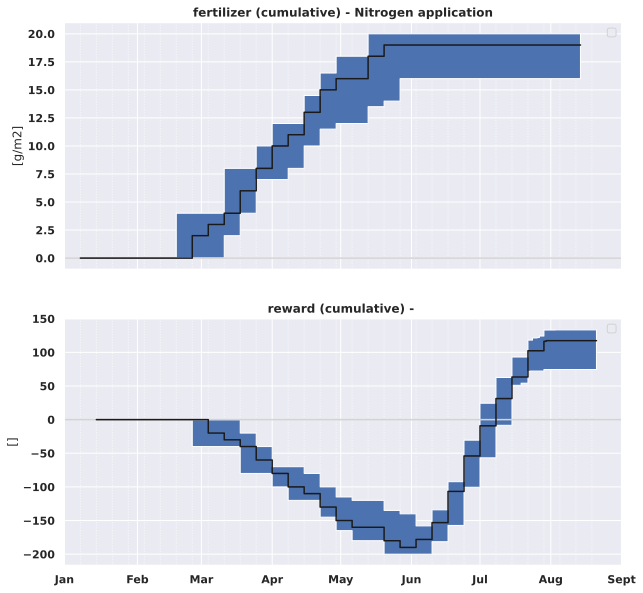

In [51]:
# Policy visualization (figure 3)
import pickle
from helper import plot_variable, get_ylim_dict

# Load paper results from disk
# A few cells below you can generate your own results with one of the available models, or one of the baselines
with open(os.path.join(resultsdir,'results_RL.pickle'), 'rb') as f:
  plot_results = pickle.load(f)

%config InlineBackend.figure_format = 'svg'
sns.set_theme(font_scale=1.00)

all_variables = list(list(plot_results.values())[0][0].keys())
all_years = list(set([k[0] for k in list(plot_results.keys())]))
all_locations = list(set([k[1] for k in list(plot_results.keys())]))
print(f'Available variables: {all_variables}')
print(f'Available years: {all_years}')
print(f'Available locations: {all_locations}')

# Specify plotting variables here
plot_years = test_years #[1992, 2020]
subset_keys = [(year, (52,5.5)) for year in plot_years]
results_subset = {f'{subset_key}': plot_results[subset_key] for subset_key in subset_keys}
plot_variables =  ['fertilizer', 'reward'] #, 'action', 'fertilizer','reward']

plot_average = True
if (len(plot_years)) > 5 and not plot_average: print(f'Warning: plotting {plot_years} at once; consider plot_average=True')
figsize = (5*len(plot_variables), 5*len(plot_variables))
fig, axes = plt.subplots(len(plot_variables), 1, sharex=True, figsize=figsize)  
for i, variable in enumerate(plot_variables):
  ax = axes if len(plot_variables) == 1 else axes[i]
  plot_variable(results_subset, variable=variable, cumulative_variables = ['fertilizer', 'reward', 'IRRAD','RAIN'], ax=ax, ylim=get_ylim_dict()[variable], plot_average=plot_average, put_legend=True)

In [4]:
# Statistics (table 2 and 3)
from helper import report_ci

# Specify variable to compute statistics for
var = 'WSO' #reward #fertilizer

df_merged = read_data() #read data stored on disk
df_merged = df_merged[df_merged.year % 2 == 0]

random.seed(42)    
n_boot=10000

name_var_RL = [col for col in df_merged.columns if f'{var}_RL' in col]
cols_var_RL = [df_merged.columns.get_loc(col) for col in name_var_RL]

for i, location in enumerate (['52;5.5','48;0']):
  df_boot = df_merged.loc[df_merged["location"] == location]
  boot_RL, boot_SP, boot_delta_RL_SP, boot_Ceres = [], [], [], []
  n_observations=len(df_boot.index)

  # bootstrapping
  for b in range(n_boot):
    obs = random.choices(range(n_observations), k=n_observations)
    seed = random.choices(cols_var_RL, k=n_observations)
    var_RL = df_boot.values[obs, seed]
    var_Ceres = df_boot.values[obs,[df_boot.columns.get_loc(f'{var}_Ceres')]*n_observations]
    boot_Ceres.append(np.median(var_Ceres))
    var_SP = df_boot.values[obs,[df_boot.columns.get_loc(f'{var}_SP')]*n_observations]
    delta_RL_SP = var_RL - var_SP
    boot_RL.append(np.median(var_RL))
    boot_SP.append(np.median(var_SP))
    boot_delta_RL_SP.append(np.median(delta_RL_SP))
    
  median_Ceres = np.median(df_boot[f'{var}_Ceres'])
  median_SP = np.median(df_boot[f'{var}_SP'])
  median_RL = np.median(pd.concat([df_boot[col] for col in name_var_RL]).to_numpy())
  median_diff = np.median(pd.concat([df_boot[col] - df_boot[f'{var}_SP'] for col in name_var_RL]).to_numpy())

  print(f'**{location_to_label[location]}**')
  print(f'median_Ceres: {median_Ceres:0.2f} {report_ci(boot_Ceres)}')
  print(f'median_SP: {median_SP:0.2f} {report_ci(boot_SP)}[')
  print(f'median_RL: {median_RL:0.2f} {report_ci(boot_RL)}]')
  print(f'median_RL-SP: {median_diff:0.2f} {report_ci(boot_delta_RL_SP, True)}')

**NL**
median_Ceres: 8.96 (95% CI=8.41 9.14)
median_SP: 8.72 (95% CI=8.13 8.94)[
median_RL: 8.81 (95% CI=8.24 9.13)]
median_RL-SP: 0.13 (95% CI=-0.01 0.39) one-sided-p=0.0290
**FR**
median_Ceres: 8.60 (95% CI=4.69 9.60)
median_SP: 8.50 (95% CI=5.80 9.13)[
median_RL: 8.45 (95% CI=5.80 9.13)]
median_RL-SP: -0.04 (95% CI=-0.17 0.13) one-sided-p=0.6459


<ipython-input-8-6cc7fbd4b493>:51: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)


/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results/image-scatter-reward-NL.png
/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results/image-scatter-fertilizer-NL.png


<ipython-input-8-6cc7fbd4b493>:51: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "." (-> marker='.'). The keyword argument will take precedence.
  _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)


/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results/image-scatter-fertilizer-NL.png


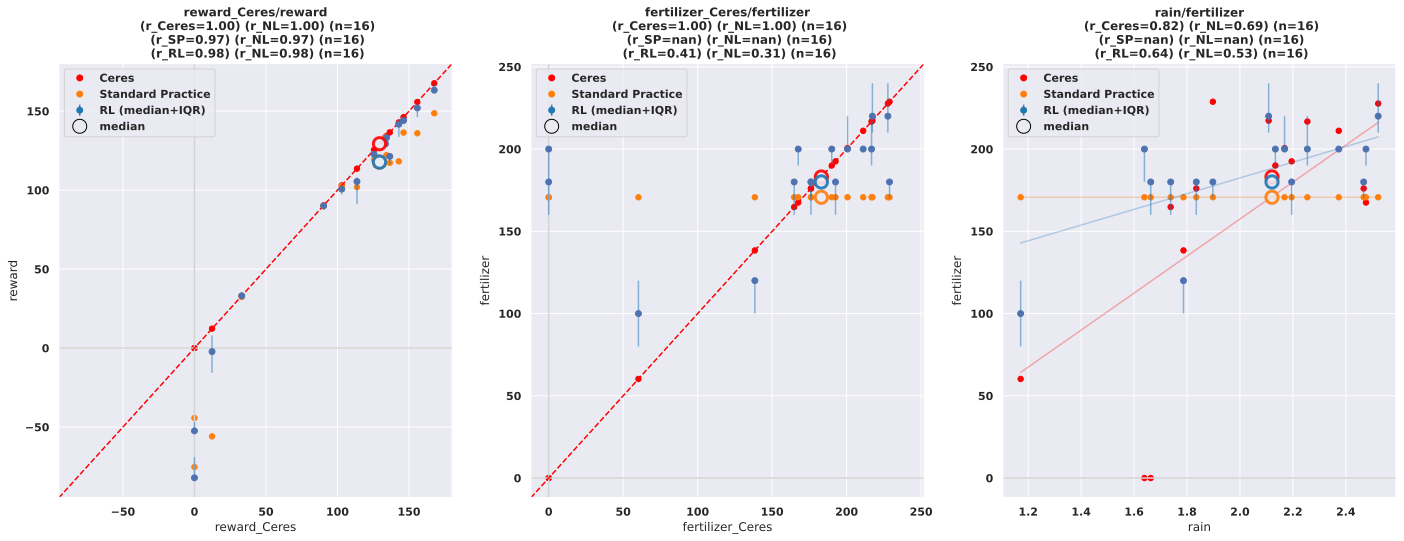

In [8]:
# Scatter plots (figure 2 and 4)

%config InlineBackend.figure_format = 'svg'
from matplotlib.container import ErrorbarContainer
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines
from sklearn.linear_model import Ridge

from helper import identity_line


# specify which variables to plot
markers = {'52;5.5':'o'} # alternatives e.g. {'52;5.5':'o', '48;0':'^'}
plots = {0:('reward_Ceres', 'reward'), 1:('fertilizer_Ceres', 'fertilizer'), 2:('rain', 'fertilizer')} #2:('WSO_Ceres', 'WSO')}
modes = ['Ceres', 'SP', 'RL']
do_annotate = False

df_merged = read_data()
df_merged = df_merged[df_merged.year % 2 == 0] #only include test years (even years)

sns.set_theme(font_scale=1.00)
location=list(markers.keys())[0]
line = mlines.Line2D([], [], marker=markers[location], color=colors['RL'], linestyle='None', markersize=6)
capline = mlines.Line2D([], [], marker=markers[location], color=colors['RL'], linestyle='None', markersize=0)
barline = LineCollection(np.empty((2,2,2)))
RL= ErrorbarContainer((line, [capline], [barline]), has_xerr=False, has_yerr=True, label='RL (median+IQR)')

fig, axes_scatter = plt.subplots(1, len(plots), figsize=(len(plots)*8,8), sharey='col', sharex='col')
ax_scatter = axes_scatter if len(plots) == 1 else axes_scatter[0]

legend_elements = [mlines.Line2D([], [], marker=markers[location], color=colors['Ceres'], linestyle='None', label='Ceres', markersize=6),
                   mlines.Line2D([], [], marker=markers[location], color=colors['SP'], linestyle='None', label='Standard Practice', markersize=6),
                   RL,
                   mlines.Line2D([], [], marker=markers[location], color='black', linestyle='None', label='median', markersize=14, markerfacecolor=ax_scatter.get_facecolor())]

for p, (x_orig, y_orig) in plots.items():
  same_units = (x_orig.split('_', 1)[0] == y_orig.split('_', 1)[0])
  do_regression = not same_units
  ax_scatter = axes_scatter if len(plots) == 1 else axes_scatter[p]
  title = f'{x_orig}/{y_orig}'
  for i, m in enumerate(modes):
    x = f'{x_orig}'
    y = f'{y_orig}_RL_1' if m == 'RL' else f'{y_orig}_{m}'
    r = df_merged[x].corr(df_merged[y])
    title = title + f'\n (r_{m}={r:0.2f})'
    for i, location in enumerate (list(markers.keys())):
      df_scatter = df_merged.loc[df_merged["location"] == location]
      r = df_scatter[x].corr(df_scatter[y])
      title = title + f' (r_{location_to_label[location]}={r:0.2f}) (n={len(df_scatter[x])})'
      if m == 'RL':
        name_var_RL = [col for col in df_scatter.columns if f'{y_orig}_RL' in col]
        y_median = np.median(df_scatter[name_var_RL], axis=1)
        q25, q75 = np.percentile(df_scatter[name_var_RL], [25, 75], axis=1)
        asymmetric_error = np.array(list(zip(y_median-q25, q75-y_median))).T
        _, caps, bars = ax_scatter.errorbar(x=df_scatter[x], y=y_median, yerr=asymmetric_error, fmt='.', ecolor=colors[m], marker=markers[location], capsize=0)
        [bar.set_alpha(0.5) for bar in bars]
        [cap.set_alpha(0.5) for cap in caps]
      else:
        y_median = df_scatter[y].values
        ax_scatter.scatter(df_scatter[x], df_scatter[y], s=30, color=colors[m], marker=markers[location])

      if do_regression:
        reg, = ax_scatter.plot([], [],color=colors[m], alpha=0.3)
        clf = Ridge(alpha=0.5)
        clf.fit(df_scatter[x].values.reshape(-1, 1), y_median.reshape(-1, 1))
        f = clf.predict
        reg.set_data([np.min(df_scatter[x]), np.max(df_scatter[x])], [f(np.min(df_scatter[x]).reshape(-1, 1)),f(np.max(df_scatter[x]).reshape(-1, 1))])    

      if do_annotate:
        df_scatter['y'] = y_median
        for index, row in df_scatter.iterrows():
          id = f"{row['year']}"
          ax_scatter.annotate(id, (row[x], row['y']), fontsize=6, color=colors[m]).set_alpha(.7)

      ax_scatter.scatter(np.median(df_scatter[x]), np.median(df_scatter[y]), s=150, edgecolors=colors[m], marker=markers[location], facecolors=ax_scatter.get_facecolor(), linewidths=3, zorder=3).set_alpha(.9)

  if same_units:
    identity_line(ax=ax_scatter, color=colors['Ceres'])
    low_x, high_x = ax_scatter.get_xlim()
    low_y, high_y = ax_scatter.get_ylim()
    low = min(low_x, low_y)
    high = max(high_x, high_y)
    ax_scatter.set_xlim(low, high)
    ax_scatter.set_ylim(low, high)
  
  if (x_orig.split('_', 1)[0] in ['fertilizer', 'reward']): ax_scatter.axvline(x=0, color='lightgrey', zorder=1)
  if (y_orig.split('_', 1)[0] in ['fertilizer', 'reward']): ax_scatter.axhline(y=0, color='lightgrey', zorder=1)
  ax_scatter.set_xlabel(f'{x}')
  ax_scatter.set_ylabel(f'{y_orig}')
  ax_scatter.set_title(f'{title}')
  ax_scatter.yaxis.set_label_coords(-.1, 0.5)
  ax_scatter.legend(handles=legend_elements, loc='upper left')

  print(f'{resultsdir}/image-scatter-{y_orig}-{location_to_label[location]}.png')    
  fig.savefig(f'{resultsdir}/image-scatter-{y_orig}-{location_to_label[location]}.png')

In [ ]:
# Evaluate "RL agent" (trained model from disk)
from tqdm.notebook import tqdm_notebook
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3 import PPO

from wrapper import ReferenceEnv
from helper import evaluate_policy, save_results

model_path = os.path.join(resultsdir,'models/model-1.zip')
stats_path = os.path.join(resultsdir,'models/model-1.pkl')
costs_nitrogen = 10.0
crop_features = ["DVS", "TGROWTH", "LAI", "NUPTT", "TRAN", "TNSOIL", "TRAIN", "TRANRF", "WSO"]
weather_features = ["IRRAD", "TMIN", "RAIN"]
action_features = []
custom_objects = {"lr_schedule": lambda x: 0.0002, "clip_range": lambda x: 0.3}
model_cropgym = PPO.load(model_path, custom_objects=custom_objects, device='cuda', print_system_info=False)
if False: print(model_cropgym.policy)

# Evaluate RL agent and store state variables in dictionaries
rewards_model, results_model = {}, {}
for test_year in tqdm_notebook(all_years):
  for location in list(set(test_locations)):    
    env_pcse_evaluation = ReferenceEnv(crop_features=crop_features,
      action_features=action_features,
      weather_features=weather_features,
      costs_nitrogen=costs_nitrogen,
      years=test_year, locations=location,
      action_space=gym.spaces.Discrete(3), action_multiplier=2.0
      )
    env_pcse_evaluation = DummyVecEnv([lambda: env_pcse_evaluation])
    env_pcse_evaluation = VecNormalize.load(stats_path, env_pcse_evaluation)
    env_pcse_evaluation.training, env_pcse_evaluation.norm_reward = False, True
    my_key = (test_year, location)
    rewards_model[my_key], results_model[my_key] = evaluate_policy(model_cropgym, env_pcse_evaluation, amount=1)
save_results(results_model, f'{os.path.join(inputdir, "RL-model.csv")}')

# Evaluate baseline agents "Standard Practice" and "Null Agent"
rewards_standard_practice, results_standard_practice = {}, {}
rewards_zero, results_zero = {}, {}
amount_SP = 17.07
for test_year in tqdm_notebook(all_years):
  for location in list(set(test_locations)):
    my_key = (test_year, location)
    env_test = ReferenceEnv(costs_nitrogen=costs_nitrogen, years=test_year, locations=location)
    env_test = VecNormalize(DummyVecEnv([lambda: env_test]), norm_obs=True, norm_reward=True, clip_obs=10.,clip_reward=50., gamma=1)
    rewards_standard_practice[my_key], results_standard_practice[my_key] = evaluate_policy('start-dump', env_test, amount=amount_SP)
    rewards_zero[my_key], results_zero[my_key] = evaluate_policy('start-dump', env_test, amount=0.00)
save_results(results_standard_practice, f'{os.path.join(inputdir, "SP.csv")}')
save_results(results_zero, f'{os.path.join(inputdir, "zero.csv")}')

In [ ]:
# Let's have a look at some specifics of the training
log_dir = '/content/PCSE-Gym/notebooks/nitrogen-winterwheat/results/tensorboard_logs'
%load_ext tensorboard
%tensorboard --logdir $log_dir